<IPython.core.display.Javascript object>


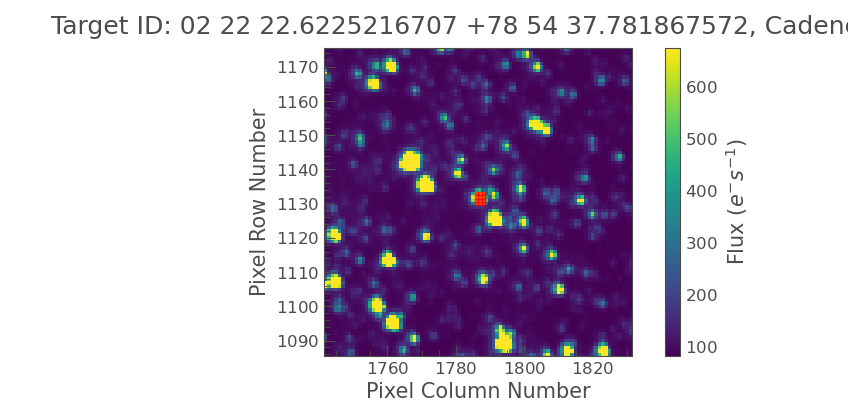

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


In [1]:
import tessreduce as tr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import lightkurve as lk
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import  FK4
coords = ["02:22:22.6225216707 +78:54:37.781867572"]
c = SkyCoord(coords, frame=FK4, unit=(u.hourangle, u.deg))
tpf_b18 = lk.search_tesscut("02 22 22.6225216707 +78 54 37.781867572", sector=18).download(cutout_size = 90)
tpf_t = tr.Get_TESS(c.ra.degree,c.dec.degree,90,18)
aper_b18 = np.zeros(tpf_b18.shape[1:], dtype=bool)
aper_b18[44:48, 44:47] = True
dict18 = tr.Quick_reduce(tpf_t, aper=aper_b18, bin_size=0, all_output=True)

<IPython.core.display.Javascript object>


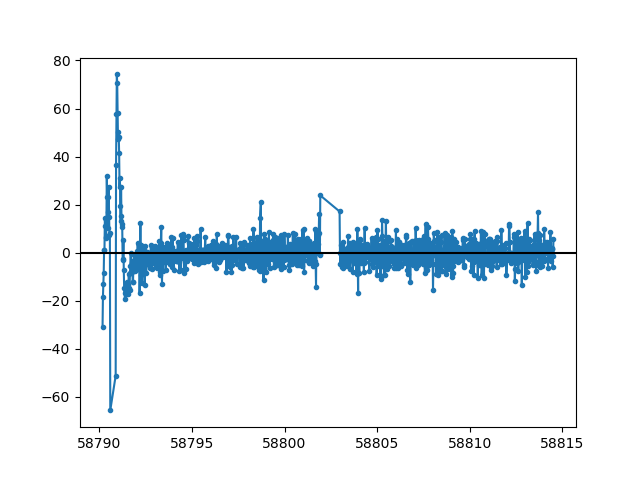

In [2]:
plt.figure()
plt.plot(dict18['lc'][0],np.gradient(dict18['lc'][1]),'.-')
plt.axhline(0,color='k')
#plt.plot(bkglc[0],bkglc[1])

In [8]:
lc = dict18['lc']
from scipy.signal import savgol_filter
from astropy.stats import sigma_clip

In [56]:
size = int(lc.shape[1] * 0.2)
if size / 2 == int(size/2): size += 1
smooth = savgol_filter(lc[1,:],size,3)
mask = sigma_clip(lc[1]-smooth,sigma_upper=3,
                    sigma_lower=4,masked=True).mask

In [57]:
mask

array([False, False, False, ..., False, False, False])

<IPython.core.display.Javascript object>


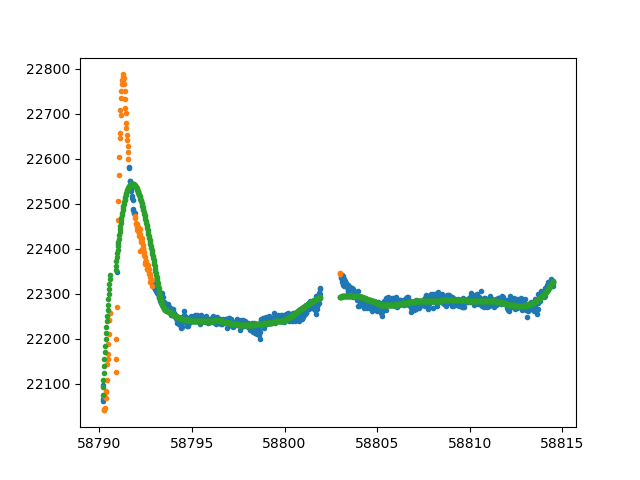

In [58]:
plt.figure()
plt.plot(lc[0][~mask],lc[1][~mask],'.')
plt.plot(lc[0][mask],lc[1][mask],'.')
plt.plot(lc[0],smooth,'.')

<IPython.core.display.Javascript object>


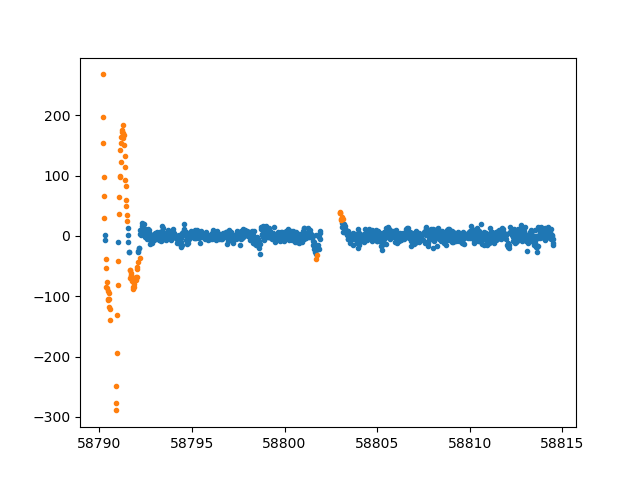

In [52]:
plt.figure()
plt.plot(lc[0][~mask],(lc[1]-smooth)[~mask],'.')
plt.plot(lc[0][mask],(lc[1]-smooth)[mask],'.')

In [20]:
from scipy.signal import find_peaks

In [32]:
x = find_peaks((lc[1]-smooth)[mask])[0]

<IPython.core.display.Javascript object>


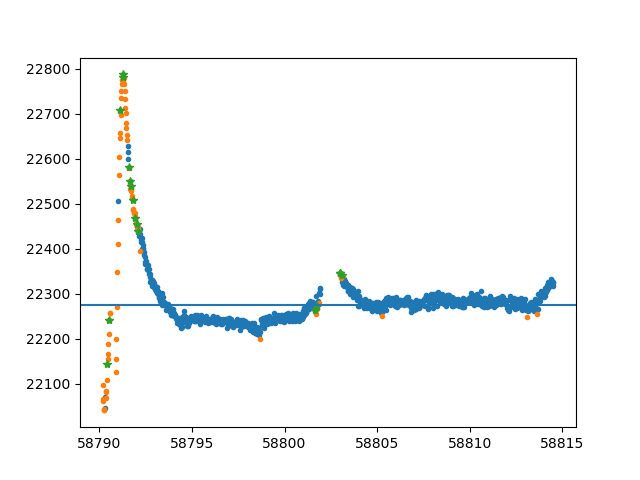

In [34]:
plt.figure()
plt.plot(lc[0][~mask],lc[1][~mask],'.')
plt.plot(lc[0][mask],lc[1][mask],'.')
plt.plot(lc[0][mask][x],lc[1][mask][x],'*')
plt.axhline(np.nanmedian(lc[1][~mask]))

In [39]:
grad = np.gradient(lc[1])
sg = savgol_filter(grad,11,2)
med = np.nanmedian(sg)
std = np.nanstd(sg)

<IPython.core.display.Javascript object>


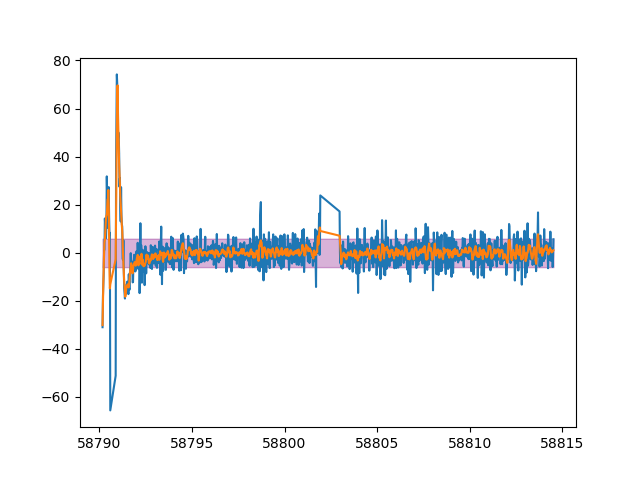

In [43]:
plt.figure()
plt.plot(lc[0],grad)
plt.plot(lc[0],sg)
plt.fill_between(lc[0],med+std,med-std,alpha=.3,color='purple')

In [59]:
r = np.arange(10)

In [63]:
r[:] = True

In [65]:
r & True

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [67]:
def sig_err(data,err=None,sig=3,maxiter=10):
    if sig is None:
        sig = 3
    clipped = data.copy()
    c_err = err.copy()
    ind = np.arange(0,len(data))
    breaker = 0
    if err is not None:
        for i in range(maxiter):
            nonan = np.isfinite(clipped)
            med = np.average(clipped[nonan],weights=1/c_err[nonan])
            #med = np.nanmedian(clipped)
            std = np.nanstd(clipped)
            mask = (clipped-1*err > med + 3*std) #| (clipped+1*err < med - 3*std)
            clipped[mask] = np.nan
            c_err[mask] = np.nan
            if ~mask.any():
                break

        mask = np.isnan(clipped)
    else:
        mask = sigma_clip(data).mask
    return mask


def Identify_masks(Obj):
    """
    Uses an iterrative process to find spacially seperated masks in the object mask.
    """
    objsub = np.copy(Obj)
    Objmasks = []

    mask1 = np.zeros((Obj.shape))
    if np.nansum(objsub) > 0:
        mask1[np.where(objsub==1)[0]] = 1
        print(mask1)
        while np.nansum(objsub) > 0:
            print(np.nansum(objsub))
            conv = ((convolve(mask1*1,np.ones(3),mode='constant', cval=0.0)) > 0)*1.0
            objsub = objsub - mask1
            objsub[objsub < 0] = 0

            if np.nansum(conv*objsub) > 0:

                mask1 = mask1 + (conv * objsub)
                mask1 = (mask1 > 0)*1
            else:

                Objmasks.append(mask1)
                mask1 = np.zeros((Obj.shape))
                if np.nansum(objsub) > 0:
                    mask1[np.where(objsub==1)[0]] = 1
    return Objmasks

def auto_tail(lc,mask,err = None):
    if err is not None:
        higherr = sigma_clip(err,sigma=2).mask
    else:
        higherr = False
    masks = Identify_masks(mask*1)
    med = np.nanmedian(lc[1][~mask & ~higherr])
    std = np.nanstd(lc[1][~mask & ~higherr])

    if lc.shape[1] > 4000:
        tail_length = 70
        start_length = 10
    else:
        tail_length = 7
        start_length = 1
            
    for i in range(len(masks)):
        m = np.argmax(lc[1]*masks[i])
        sig = (lc[1][m] - med) / std
        masks[i][int(m-sig*start_length):int(m+tail_length*sig)] = 1
        masks[i] = masks > 0
    summed = np.nansum(masks*1,axis=0)
    mask = summed > 0 
    return mask
        


def Remove_stellar_variability(lc,err=None,variable=False,sig = None, sig_up = 3, sig_low = 10, tail_length='auto'):
    """
    Removes all long term stellar variability, while preserving flares. Input a light curve 
    with shape (2,n) and it should work!

    Parameters
    ----------
    lc : array
        lightcurve with the shape of (2,n), where the first index is time and the second is 
        flux.
    sig_up : float
        upper sigma clip value 
    sig_low : float
        lower sigma clip value
    tail_length : str OR int
        option for setting the buffer zone of points after the peak. If it is 'auto' it 
        will be determined through functions, but if its an int then it will take the given 
        value as the buffer tail length for fine tuning.

    Outputs
    -------
    trends : array
        the stellar trends, subtract this from your input lc
    """
    # Make a smoothing value with a significant portion of the total 
    if vaiable:
        size = int(lc.shape[1] * 0.04)
        if size / 2 == int(size/2): size += 1
        smooth = savgol_filter(lc[1,:],size,3)
        mask = sig_err(lc[1]-smooth,err,sig=sig)
        #sigma_clip(lc[1]-smooth,sigma=sig,sigma_upper=sig_up,
        #                    sigma_lower=sig_low,masked=True).mask
    else:
        mask = sig_err(lc[1],err,sig=sig)
        
    ind = np.where(mask)[0]
    masked = lc.copy()
    # Mask out all peaks, with a lead in of 5 frames and tail of 100 to account for decay
    # todo: use findpeaks to get height estimates and change the buffers accordingly
    if type(tail_length) == str:
        if tail_length == 'auto':
            print(auto)
            m = auto_tail(lc,mask,err)
            masked[m] = np.nan
        else:
            if lc.shape[1] > 4000:
                tail_length = 100
                start_length = 1
            else:
                tail_length = 10
            for i in ind:
                masked[:,i-5:i+tail_length] = np.nan
    else:
        tail_length = int(tail_length)
        if type(tail_length) != int:
            raise ValueError("tail_length must be either 'auto' or an integer")
        for i in ind:
            masked[:,i-5:i+tail_length] = np.nan
    
    finite = np.isfinite(masked[1,:])
    ## Hack solution doesnt need to worry about interpolation. Assumes that stellar variability 
    ## is largely continuous over the missing data regions.
    #f1 = interp1d(lc[0,finite], lc[1,finite], kind='linear',fill_value='extrapolate')
    #interp = f1(lc[0,:])

    # Smooth the remaining data, assuming its effectively a continuous data set (no gaps)
    size = int(lc.shape[1] * 0.005)
    if size / 2 == int(size/2): size += 1
    smooth = savgol_filter(lc[1,finite],size,1)
    # interpolate the smoothed data over the missing time values
    f1 = interp1d(lc[0,finite], smooth, kind='linear',fill_value='extrapolate')
    trends = f1(lc[0])
    # huzzah, we now have a trend that should remove stellar variability, excluding flares.
    return trends 